### Setup
## Imports

In [1]:
from itertools import chain
import ujson as json
import multiprocessing as mp
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import ShuffleSplit
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_fscore_support

from helpers import disaggregated_df
from helpers import aggregated_df
from helpers import dummify_df
from helpers import lr_train_tester

%matplotlib inline
sns.set(font='monospace')
df = pd.read_pickle('../../data/merged/data_to_use_by_ad.pkl')

In [2]:
print(df.columns)

Index(['class', 'phone', 'dd_id', 'price', 'duration_in_mins', 'flag', 'age',
       'area', 'area_type', 'ethnicity', 'cdr_id', 'price_per_min', 'Disease',
       'Year', 'Cases', 'Rate', 'MSA', 'property', 'rape', 'violent',
       'male_wage_mean', 'male_wage_p05', 'male_wage_p10', 'male_wage_p25',
       'male_wage_p50', 'male_wage_p75', 'male_wage_p90', 'male_wage_p95',
       'male_N', 'male_epop', 'qcew_code', 'msa', 'population', 'unemployment',
       'lt_highschool', 'highschool', 'some_college', 'college_plus',
       'frac_white', 'avg_commute', 'female_wage_mean', 'wage_var.wage',
       'female_wage_p05', 'female_wage_p10', 'female_wage_p25',
       'female_wage_p50', 'female_wage_p75', 'female_wage_p90',
       'female_wage_p95', 'female_N', 'wage_sum.wght', 'female_epop',
       'swnauthemp', 'swnftemp', 'ad_p10_msa', 'ad_p90_msa', 'ad_mean_msa',
       'ad_median_msa', 'ad_count_msa', 'ad_p50_msa'],
      dtype='object')


In [3]:
df['class'] = df['class'].apply(lambda x: True if x == 'positive' else False)
df['lt_23'] = df.age.apply(lambda x: True if x < 23 else False)

In [4]:
agg_category_cols = ['flag', 'ethnicity']
for a_c_c in agg_category_cols:
    df = dummify_df(df, a_c_c, '|')
    print('post-{}: {}'.format(a_c_c, df.shape))

post-flag: (144121, 73)
post-ethnicity: (144121, 101)


In [5]:
a = df.ix[:, ['dd_id', 'class']]
print(a.shape)
print(a.drop_duplicates().shape)

(144121, 2)
(28026, 2)


### Plotting indicators
Visual exploration of TGG & other indicators in the data. These graphs are done on ads. If you want to run 'em on phones, you should disambiguate differently.

#### Flags

(28026, 14)


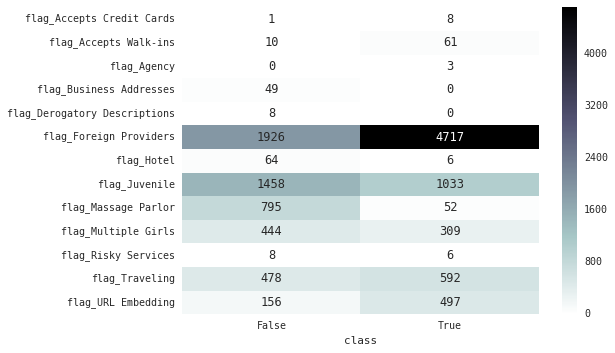

In [6]:
cols = [x for x in df.columns if x.split('_')[0] == 'flag']
a = df.ix[:, ['dd_id', 'class']+cols].drop_duplicates().ix[:, ['class']+cols]
print(a.shape)
ct = a.groupby('class').sum()
sns.heatmap(ct.T, annot=True, fmt='d', cmap='bone_r')

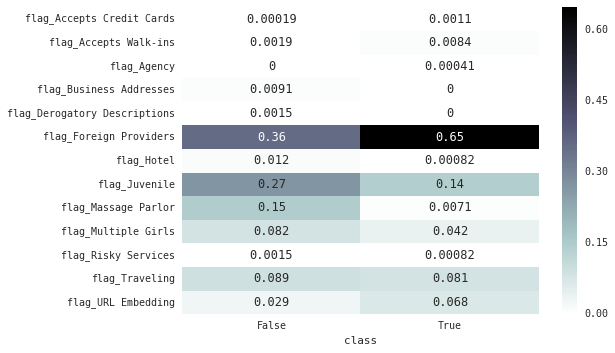

In [7]:
sns.heatmap(ct.T/ct.sum(axis=1), annot=True, cmap='bone_r')

#### Ethnicity

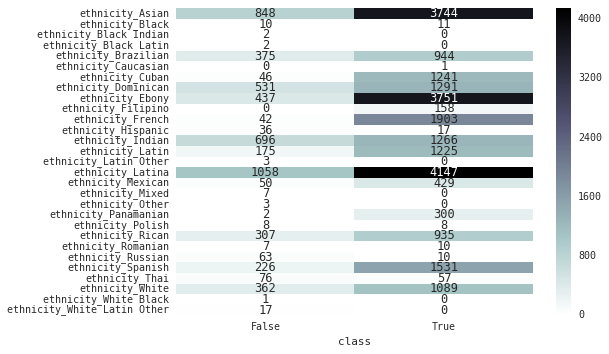

In [8]:
cols = [x for x in df.columns if x.split('_')[0] == 'ethnicity']
a = df.ix[:, ['dd_id', 'class']+cols].drop_duplicates().ix[:, ['class']+cols]
ct = a.groupby('class').sum()
sns.heatmap(ct.T, annot=True, fmt='d', cmap='bone_r')

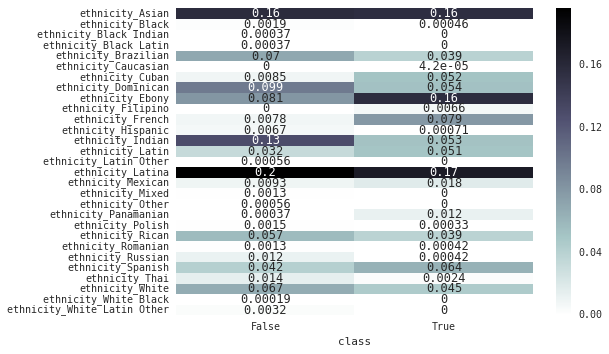

In [9]:
sns.heatmap(ct.T/ct.sum(axis=1), annot=True, cmap='bone_r')

#### Price

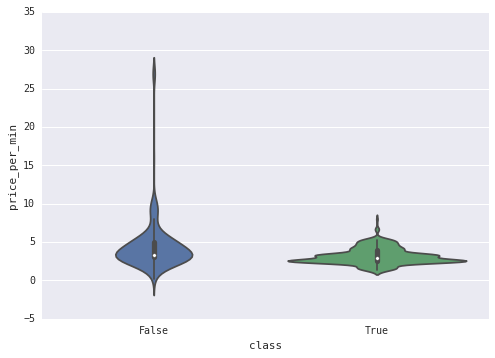

In [10]:
a = df.ix[:, ['dd_id', 'class', 'price_per_min']].dropna().drop_duplicates().ix[:, ['class', 'price_per_min']]
sns.violinplot(a['class'], a['price_per_min'])

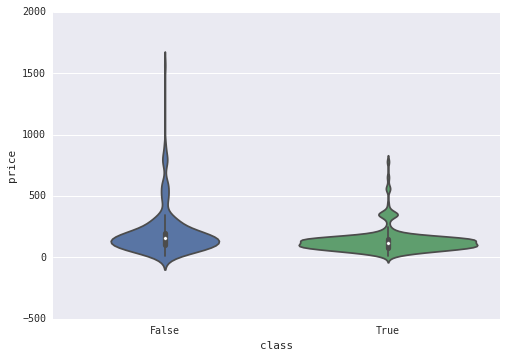

In [11]:
a = df.ix[:, ['dd_id', 'class', 'price']].dropna().drop_duplicates().ix[:, ['class', 'price']]
sns.violinplot(a['class'], a['price'])

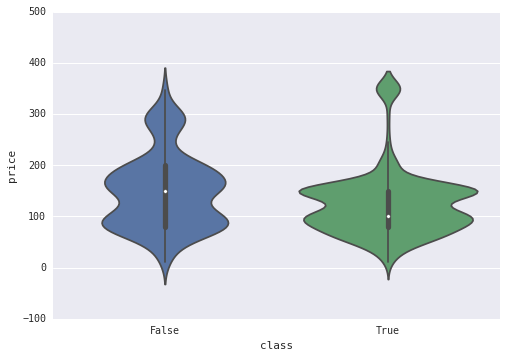

In [12]:
sns.violinplot(a.ix[(a.price < 400), 'class'], a.ix[(a.price < 400), 'price'])

#### Age

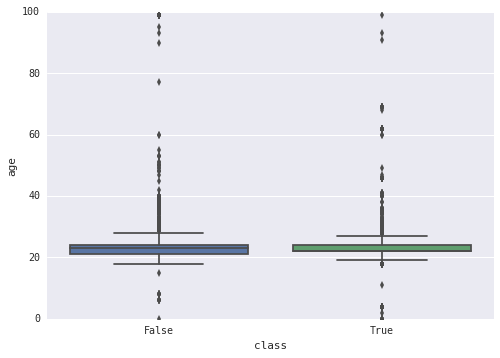

In [13]:
a = df.ix[:, ['dd_id', 'class', 'age']].dropna().drop_duplicates().ix[:, ['class', 'age']]
sns.boxplot(a['class'], a['age'])

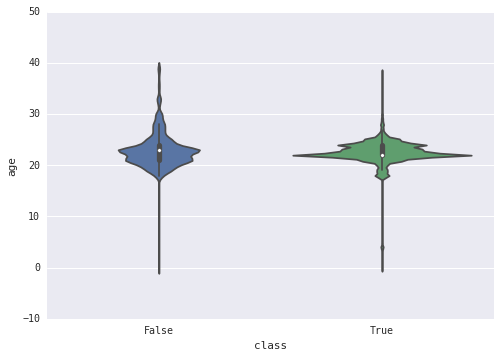

In [14]:
sns.violinplot(a.ix[(a.age < 40), 'class'], a.ix[(a.age < 40), 'age'])

# Classifiers
## Linreg

We're using simple folds. These should perhaps be improved to deal with demographic bias.

### Slice DF

In [15]:
flag_cols = [x for x in df.columns if x.split('_')[0] == 'flag']
eth_cols = [x for x in df.columns if x.split('_')[0] == 'ethnicity']

cols_to_use = ['age',
               'price',
               'duration_in_mins',
               'price_per_min'] + flag_cols + eth_cols

df_slice = df.ix[:, ['class',
                     'phone',
                     'dd_id'] + cols_to_use].copy().drop_duplicates()

print(df_slice.shape)

# Fill NAs
for col in ['age', 'price', 'duration_in_mins', 'price_per_min']:
    df_slice['no_{}'.format(col)] = df_slice[col].apply(np.isnan)
    df_slice[col] = df_slice[col].fillna(0)
    
cols_to_use += [x for x in df.columns if x[:3] == 'no_']

# Dropped duplicates should kill identical ads
# WE NEED TO GROUP ON PHONES
# But I'm not going to think about that right now, so ads it is
df_X = df_slice.ix[:, cols_to_use]
y_series = df_slice['class'].astype(int)
print(df_X.shape)
print(y_series.shape)

(29519, 49)
(29519, 46)
(29519,)


### Get Train / Test splits, folds, or whatever you want to call them
Splitting *after* dropping a bunch of duplicates. We want the phone number to be the primary key.

In [16]:
splitter = ShuffleSplit(df_X.shape[0], 10)
splits = [x for x in splitter]

### Run model

In [17]:
p = mp.Pool(10)
lrs = p.starmap(lr_train_tester,
                [(df_X.iloc[train_ix, :],
                  y_series.iloc[train_ix],
                  df_X.iloc[test_ix, :],
                  y_series.iloc[test_ix])
                 for train_ix, test_ix in splits])
p.close()
p.join()

In [18]:
pd.Series([lr['lr_score'] for lr in lrs]).describe()

count    10.000000
mean      0.204474
std       0.006541
min       0.195821
25%       0.200838
50%       0.203498
75%       0.208752
max       0.215583
dtype: float64

In [19]:
pd.Series([lr['roc']['auc'] for lr in lrs]).describe()

count    10.000000
mean      0.751824
std       0.005964
min       0.743250
25%       0.749409
50%       0.750736
75%       0.756684
max       0.760224
dtype: float64

With these splits and features, our linear model _juuuuust_ a little better than the mean. Thanks, skewed data :(

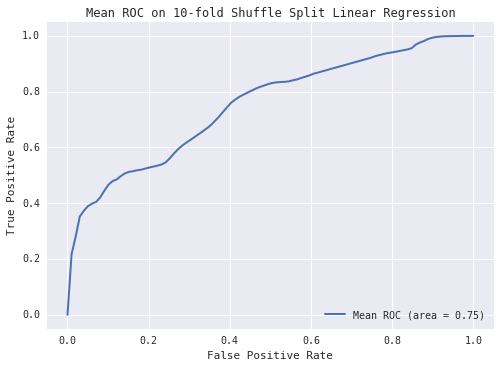

In [20]:
from scipy import interp

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for lr in lrs:
    mean_tpr += interp(mean_fpr, lr['roc']['fpr'], lr['roc']['tpr'])
    mean_tpr[0] = 0.0
    
mean_tpr /= len(lrs)
mean_tpr[-1] = 1.0

plt.plot(mean_fpr, mean_tpr,
         label='Mean ROC (area = %0.2f)' % pd.Series([lr['roc']['auc'] for lr in lrs]).describe()['mean'], lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Mean ROC on 10-fold Shuffle Split Linear Regression')
plt.legend(loc="lower right")
plt.show()